In [1]:
# import libraries

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [2]:
RANDOM_STATE = 0
np.random.seed(RANDOM_STATE)
rng = np.random.default_rng(seed=RANDOM_STATE)

TEST_SIZE = 0.2
NOISE = 0.2
ALPHA = 0.1
N_SAMPLES = 1000
EPOCHS=50001

# parameters for Matplotlib
params = {'legend.fontsize': 'medium',
          'figure.figsize': (15, 6),
          'axes.labelsize': 'large',
          'axes.titlesize':'large',
          'xtick.labelsize':'medium',
          'ytick.labelsize':'medium'
         }

CMAP = plt.cm.jet

plt.rcParams.update(params)

In [3]:
X, y  = datasets.make_moons(n_samples=N_SAMPLES,
                            shuffle=True,
                            noise=NOISE,
                            random_state=RANDOM_STATE)

X.shape, y.shape

((1000, 2), (1000,))

In [4]:
X[:5], y[:5]

(array([[ 2.08614399,  0.57401401],
        [ 1.80460944,  0.00695963],
        [-0.22711217,  0.57390962],
        [-0.2512257 ,  0.18768179],
        [ 0.42574411, -0.41424666]]),
 array([1, 1, 0, 1, 1]))

In [5]:
data_df = pd.DataFrame(X, columns = ['A', 'B']) # Put X in a dataframe
data_df['target'] = y
data_df.head()

,A,B,target
0,2.086144,0.574014,1
1,1.804609,0.006960,1
2,-0.227112,0.573910,0
3,-0.251226,0.187682,1
4,0.425744,-0.414247,1


In [6]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A       1000 non-null   float64
 1   B       1000 non-null   float64
 2   target  1000 non-null   int64  
dtypes: float64(2), int64(1)
memory usage: 23.6 KB


In [7]:
data_df.describe()

,A,B,target
count,1000.000000,1000.000000,1000.00000
mean,0.502443,0.247483,0.50000
std,0.891263,0.537689,0.50025
min,-1.384649,-0.999762,0.00000
25%,-0.103916,-0.213908,0.00000
50%,0.476316,0.252560,0.50000
75%,1.138137,0.686127,1.00000
max,2.454286,1.536515,1.00000


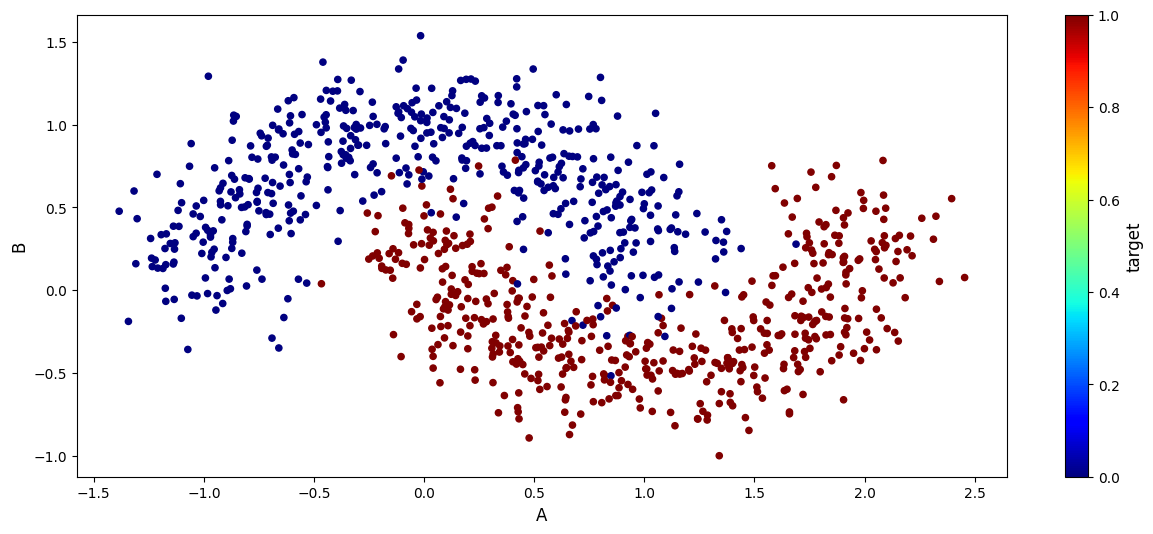

In [8]:
data_df.plot.scatter('A', 'B', s = 20, c = 'target', cmap = plt.cm.jet);

In [9]:
y = pd.get_dummies(y).to_numpy()
y

array([[False,  True],
       [False,  True],
       [ True, False],
       ...,
       [False,  True],
       [False,  True],
       [False,  True]])

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= TEST_SIZE, stratify = y, random_state=RANDOM_STATE)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((800, 2), (200, 2), (800, 2), (200, 2))

In [11]:
def fn_softmax(z):
  exp_sc = np.exp(z)
  return exp_sc / np.sum(exp_sc, axis=1, keepdims = True)

whenever you code a function check it by running

In [12]:
sm = fn_softmax(np.array([[-1., 0., 1.],[-10, 0., 10]]))
display(sm)

sm.sum(axis=1)

array([[9.00305732e-02, 2.44728471e-01, 6.65240956e-01],
       [2.06106005e-09, 4.53978686e-05, 9.99954600e-01]])

array([1., 1.])

In [13]:
def fn_activ(z):
    return np.tanh(z)

def fn_activ_prime(a):
    return 1.0 - (np.tanh(a))**2

In [14]:
fn_activ(np.array([[-1., 0., 1.],[-np.inf, 0., np.inf]]))

array([[-0.76159416,  0.        ,  0.76159416],
       [-1.        ,  0.        ,  1.        ]])

In [15]:
1.0 - (np.tanh(0.5))**2

np.float64(0.7864477329659274)

In [16]:
fn_activ_prime(0.5)

np.float64(0.7864477329659274)

In [17]:
fn_activ_prime(np.array([[-1., 0., 1.],[-np.inf, 0., np.inf]]))

array([[0.41997434, 1.        , 0.41997434],
       [0.        , 1.        , 0.        ]])

In [18]:
def predict(model, X_p):
      W1 = model['W1']
      b1 = model['b1']
      W2 = model['W2']
      b2 = model['b2']
      ### Forward Propagation
      ## Layer-1
      z1 = X_p.dot(W1) + b1   # Aggreagtion
      a1 = fn_activ(z1)     # Activation function

      ## Layer-2
      z2 = a1.dot(W2) + b2  # Aggregaion
      a2 = fn_softmax(z2)   # Activation function
      return a2 >= 0.5

In [19]:
def calculate_loss(model, X_l, y_l):
      W1 = model['W1']
      b1 = model['b1']
      W2 = model['W2']
      b2 = model['b2']
      m = X_l.shape[0]

      ### Forward Propagation
      ## Layer-1
      z1 = X_l.dot(W1) + b1   # Aggreagtion
      a1 = fn_activ(z1)     # Activation function

      ## Layer-2
      z2 = a1.dot(W2) + b2  # Aggregaion
      a2 = fn_softmax(z2)   # Activation function
      loss = -(y_l * np.log(a2)+(1-y_l)*np.log(1-a2)).sum()/ m
      return loss

In [20]:
loss_hist = {}

In [21]:
def build_model(nn_hdim,X, y, epochs= EPOCHS, alpha= ALPHA):

    m, nn_input_dim = X.shape
    nn_output_dim = y.shape[1]

    # Weights :
    # Corrected: Multiply the random values by the scaling factor
    W1 = rng.random((nn_input_dim, nn_hdim), dtype=np.float32) * (1/np.sqrt(nn_input_dim))
    W2 = rng.random((nn_hdim, nn_output_dim), dtype=np.float32) * (1/np.sqrt(nn_hdim)) # Changed nn_input_dim to nn_output_dim for W2 shape

    # bias
    # Corrected: Typo in np.zeroes, should be np.zeros
    b1 = np.zeros((1, nn_hdim), dtype=np.float32)
    b2 = np.zeros((1,nn_output_dim), dtype=np.float32)

    # Moved initialization outside the loop to avoid re-initializing every epoch
    curr_loss , loss, epochs_list = [], [], [] # Renamed epochs to epochs_list to avoid conflict with function parameter

    for i in range(0, epochs):

      ### Forward Propagation
      ## Layer-1
      z1 = X.dot(W1) + b1   # Aggreagtion
      a1 = fn_activ(z1)     # Activation function


      ## Layer-2
      z2 = a1.dot(W2) + b2  # Aggregaion
      a2 = fn_softmax(z2)   # Activation function


      ### Back Propagation
      ## Possible ERROR : The shape if the a2 and y do not match. Shape of a2 is:
      #### --------------
      ## Layer 2 :
      #### --------------
      assert(a2.shape == y.shape), f'a2 shape : {a2.shape}, y shape:{y.shape}'
      dz2 = a2 - y

      dW2 = (a1.T).dot(dz2)
      assert (dW2.shape == W2.shape), f'dW2 shape : {dW2.shape}, W2 shape:{W2.shape}'

      db2 = np.sum(dz2, axis=0, keepdims=True)
      assert (db2.shape == b2.shape), f'db2 shape : {db2.shape}  , b2 shape : {b2.shape}'

      da1 = dz2.dot(W2.T)
      assert( da1.shape == a1.shape), f'da1 shape: {da1.shape}, a1 shape : {a1.shape}'

      #### --------------
      ## Layer 1 :
      #### --------------
      dz1 = da1 * fn_activ_prime(z1)     # element wise multiplication not the dot product
      assert (dz1.shape == z1.shape), f'dz1 shape : {dz1.shape}, z1 shape : {z1.shape}'

      dW1 = (X.T).dot(dz1)
      assert (dW1.shape == W1.shape), f'dW1 shape: {dW1.shape}, W1 shape: {W1.shape}'

      db1 = np.sum(dz1, axis=0, keepdims=True)
      assert (db1.shape == b1.shape), f'db1 shape: {db1.shape}, b1 shape: {b1.shape}'


      #######################
      ### Gradient Update ###
      #######################
      W1 += -alpha * dW1 / m
      b1 += -alpha * db1 / m
      W2 += -alpha * dW2 / m
      b2 += -alpha * db2 / m # Corrected: Should update b2 with db2

      model = {'W1':W1, 'b1': b1, 'W2': W2, 'b2': b2}

      if i%100 == 0:
        curr_loss = calculate_loss(model, X, y)
        loss.append(curr_loss)
        epochs_list.append(i) # Append to epochs_list

      if i%1000 == 0 :
        print(f'INFO : Loss after {i:>5d} is {curr_loss:8.5f}')

    # update loss
    loss_hist['epoch'] = epochs_list # Use epochs_list
    loss_hist['loss'] = loss

    return model

In [22]:
y_train.shape

(800, 2)

In [23]:
model = build_model(4, X_train, y_train)
display(model)

INFO : Loss after     0 is  1.30885
INFO : Loss after  1000 is  0.56762
INFO : Loss after  2000 is  0.56544
INFO : Loss after  3000 is  0.56407
INFO : Loss after  4000 is  0.56295
INFO : Loss after  5000 is  0.56186
INFO : Loss after  6000 is  0.56073
INFO : Loss after  7000 is  0.55953
INFO : Loss after  8000 is  0.55824
INFO : Loss after  9000 is  0.55670
INFO : Loss after 10000 is  0.55297
INFO : Loss after 11000 is  0.33338
INFO : Loss after 12000 is  0.19635
INFO : Loss after 13000 is  0.17571
INFO : Loss after 14000 is  0.16911
INFO : Loss after 15000 is  0.16587
INFO : Loss after 16000 is  0.16378
INFO : Loss after 17000 is  0.16223
INFO : Loss after 18000 is  0.16097
INFO : Loss after 19000 is  0.15993
INFO : Loss after 20000 is  0.15904
INFO : Loss after 21000 is  0.15828
INFO : Loss after 22000 is  0.15760
INFO : Loss after 23000 is  0.15700
INFO : Loss after 24000 is  0.15647
INFO : Loss after 25000 is  0.15598
INFO : Loss after 26000 is  0.15553
INFO : Loss after 27000 is  

{'W1': array([[-1.53259066,  3.78209678,  3.51307633, -0.81804422],
        [-1.65820931, -1.50905794, -0.8753239 ,  1.22325951]]),
 'b1': array([[ 1.3710041 ,  1.8918285 , -4.730346  ,  0.39754137]],
       dtype=float32),
 'W2': array([[-4.18556003,  4.67982878],
        [-3.70447695,  4.48556259],
        [-4.16398497,  4.71911631],
        [-0.71264644,  1.56276612]]),
 'b2': array([[ 0.74210066, -0.74210066]], dtype=float32)}

<Axes: xlabel='epoch'>

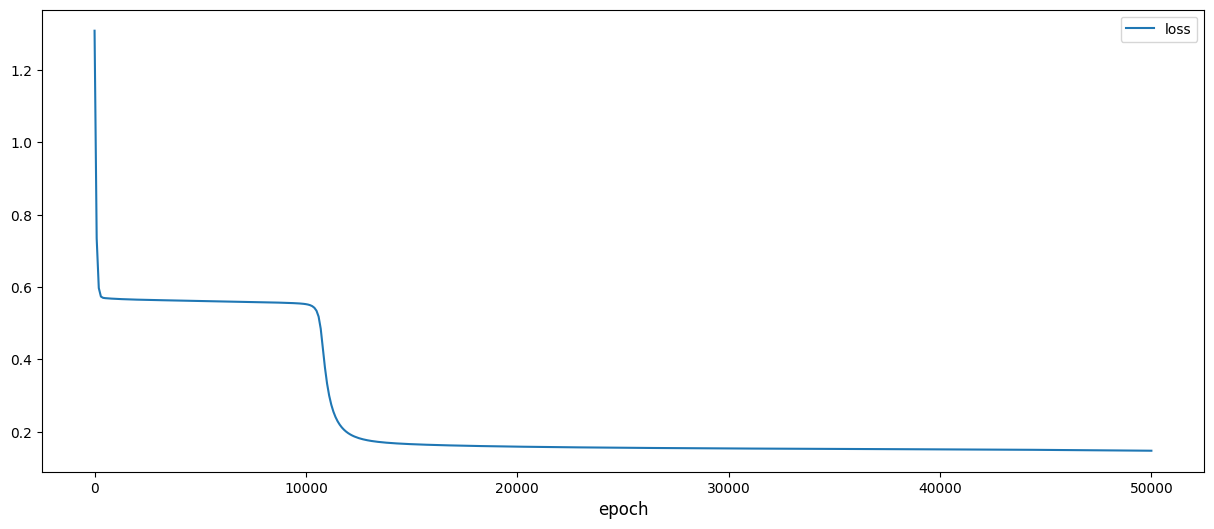

In [24]:
pd.DataFrame(loss_hist).plot(x= 'epoch', y='loss')

### Train Predictions

In [25]:
y_pred = predict(model, X_train)

print(f'Accuracy : {accuracy_score ( y_train, y_pred):7.4f}')
y_pred.shape, y_train.shape

Accuracy :  0.9725


((800, 2), (800, 2))

In [26]:
y_pred = predict(model, X_test)

print(f'Accuracy : {accuracy_score ( y_test, y_pred):7.4f}')
y_test.shape, y_pred.shape

Accuracy :  0.9600


((200, 2), (200, 2))

In [27]:
cm = confusion_matrix(y_test.argmax(axis=1), y_pred)
cm

ValueError: Classification metrics can't handle a mix of binary and multilabel-indicator targets

In [ ]:
loss_df = pd.DataFrame(loss_hist)
loss_df.head()

In [ ]:
fig, ax = plt.subplots()
loss_df.plot(x='epoch', y='loss', ax=ax)
txtstr = "Errors : \n Start : {:7.2f}\n End : {:7.2f}".format(loss_df.iloc[0]['loss'], loss_df.iloc[-1]['loss'])

props = dict(boxstyle = 'round', facecolor='cyan', alpha=0.4)

ax.text(0.75, 0.95, txtstr, transform= ax.transAxes, fontsize = 12, verticalalignment ='top', bbox = props)

ax.set_xlabel('Epochs')
ax.set_ylabel('Error')

ax.grid()

In [ ]:
y_pred = predict(model, X_train)

print(f'Accuracy : {accuracy_score ( y_train, y_pred):7.4f}')

In [ ]:
y_pred = predict(model, X_test)

print(f'Accuracy : {accuracy_score ( y_test, y_pred):7.4f}')

In [ ]:
cm = confusion_matrix(y_test, y_pred)
cm

In [ ]:
# Create plot object of confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0,1])

# initialize figure
fig, ax = plt.subplots(figsize = (4,4))

#Plot
disp.plot(ax = ax, cmap = 'Greens', colorbar=False)
# plt.grid()
plt.show();

In [ ]:
def fn_plot_decision_boundary(pred_func, X_tr, y_tr, X_ts, y_ts):
    '''
        pred_func : function making predictions using Train data,
        X_tr : training,
        y_tr : Training Labels,
        X_ts : Testing,
        y_ts = Testing Labels
    '''
    fig, ax = plt.subplots(figsize = (15,5))
    dm = 0.05
    x_min , x_max = X_tr[:,0].min() - 0.5, X_tr[:,0].max() + 0.5
    y_min , y_max = X_tr[:,1].min() - 0.5, X_tr[:,1].max() + 0.5

    x1, y1 = np.meshgrid(np.arange(x_min, x_max, dm), np.arange(y_min, y_max, dm))

    XX = np.c_[x1.ravel(), y1.ravel()]

    Z = pred_func(XX)
    Z = Z.reshape(x1.shape)

    ax.contourf(x1, y1, Z, alpha = 0.6, cmap= plt.cm.coolwarm)
    ax.scatter(X_tr[:,0], X_tr[:,1] , c= y_tr, s=15, edgecolor = 'k', cmap = plt.sm.bwr)
    ax.scatter(X_tr[:,0], X_ts[:,1] , c= y_ts, s=50, marker = '*',edgecolor = 'k', cmap = plt.sm.Paired)

In [ ]:
fn_plot_decision_boundary